In [7]:
%matplotlib inline


In [1]:
import pandas as pd
import numpy as np
import math
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import seaborn
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.plotting import plot_covariance
import riskfolio as rp
file_name = 'vanguard.csv'
symbols = ['VTV','VB', 'VTI', 'SPY','VUG','VXF','VXUS','VGK','VDE','VWO','VTIP','BND','BNDX']  

def download(file_name,symbols):
    yf_data = yf.download(symbols,  start = "2019-02-01" , end = "2022-12-01")
    newcolnames = [col[0] + col[1] for col in yf_data.columns.values]
    yf_data
    yf_data.columns = newcolnames
    yf_data.reset_index(inplace=True)
    yf_data.columns
    yf_data.to_csv(file_name, index=False) 

In [2]:
import yfinance as yf

def download_one_at_a_time():
    # Set the start and end date
    start_date = '1990-01-01'
    end_date = '2023-07-12'


    # Set the ticker
    for ticker in symbols:
        # Get the data
        data = yf.download(ticker, start_date, end_date)
        data.to_csv(ticker+".csv",index=True)

In [3]:
#download_one_at_a_time() or this one
#download(file_name,symbols)

In [4]:
df_list = []
for ticker in symbols:
    df = pd.read_csv(ticker+".csv")
    df = df.rename(columns={"Adj Close": ticker})
    df['Date'] = pd.to_datetime(df['Date'])
    df.drop(['Open', 'High', 'Low', 'Close','Volume'], axis = 1, inplace = True)
    df_list.append(df.copy())

In [5]:
df = reduce(lambda left, right: pd.merge(left, right, on="Date"), df_list)

In [6]:
file_name

'vanguard.csv'

In [7]:
df.head()

,Date,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
1,2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2,2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
3,2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
4,2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624


In [210]:
df.to_csv(file_name, index=False) 

In [229]:
df_vanguard = pd.read_csv(file_name)
df_vanguard['Date'] = pd.to_datetime(df_vanguard['Date'])
df_vanguard.head()

,Date,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
1,2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2,2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
3,2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
4,2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624


In [230]:
df_vanguard.set_index('Date', inplace=True) 
returns = df_vanguard.pct_change()

In [231]:
df_vanguard.head()

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
Date,,,,,,,,,,,,,
2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624


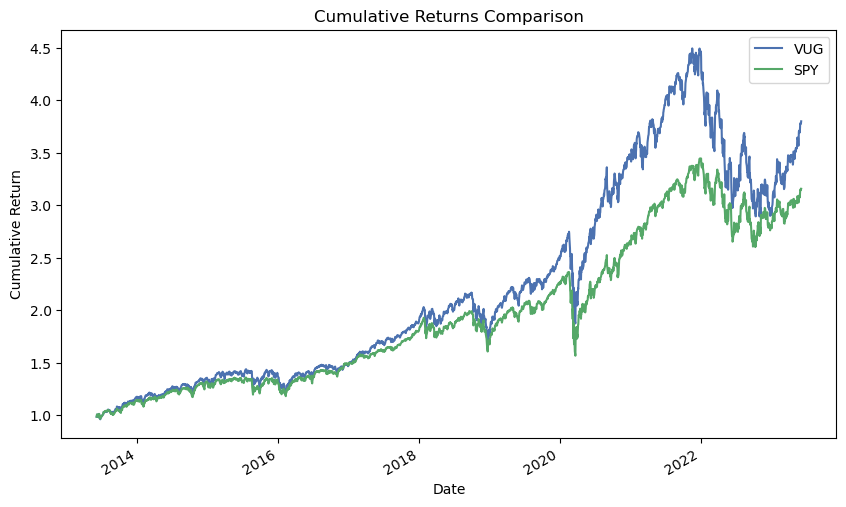

In [232]:
cum_returns = (1 + returns).cumprod()
cum_returns[["VUG","SPY"]].plot(figsize=(10, 6))
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


<Axes: xlabel='Date'>

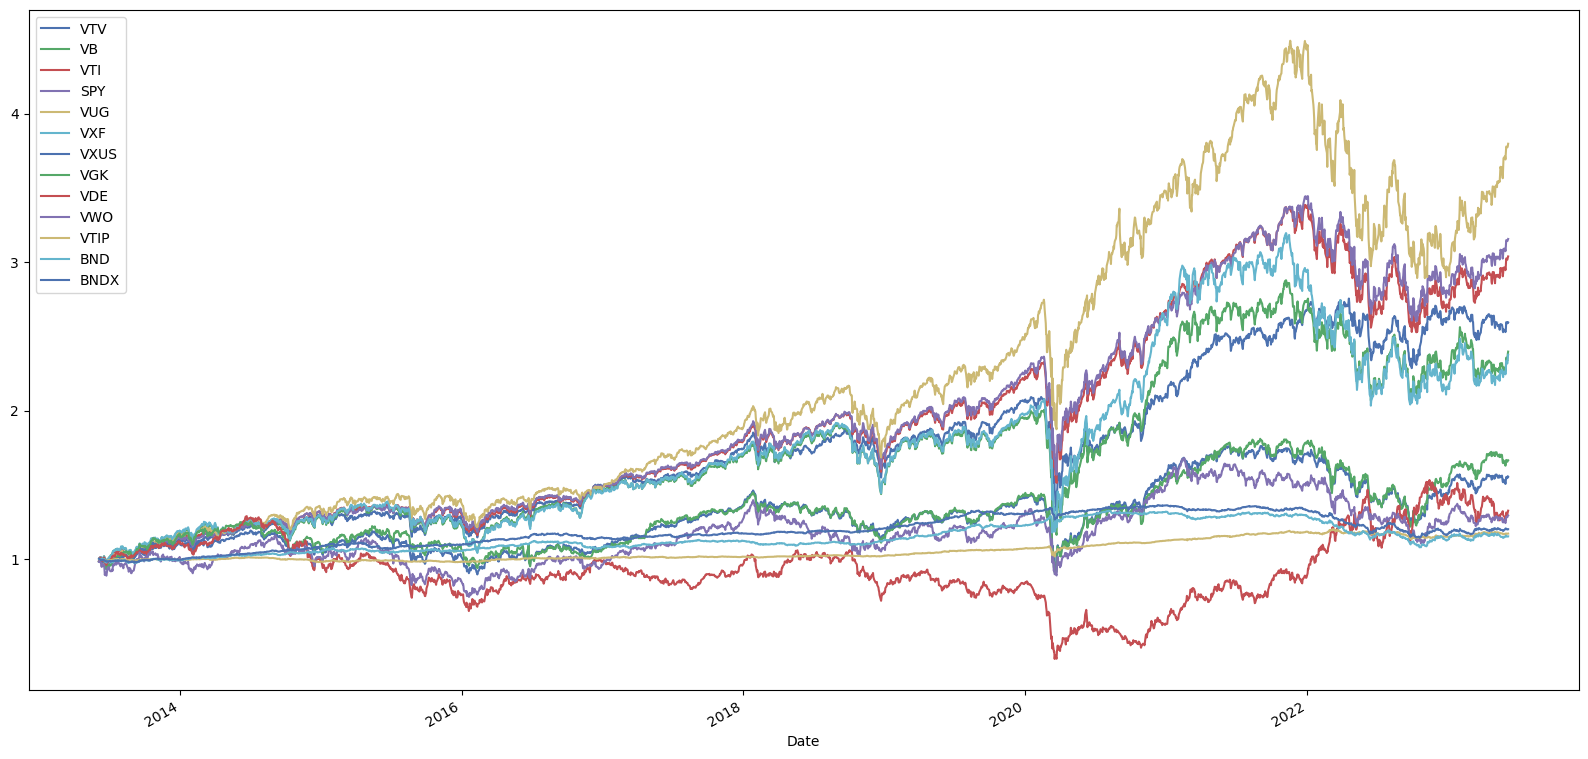

In [233]:
cum_returns.plot()

In [234]:
df_vanguard.head()

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
Date,,,,,,,,,,,,,
2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624


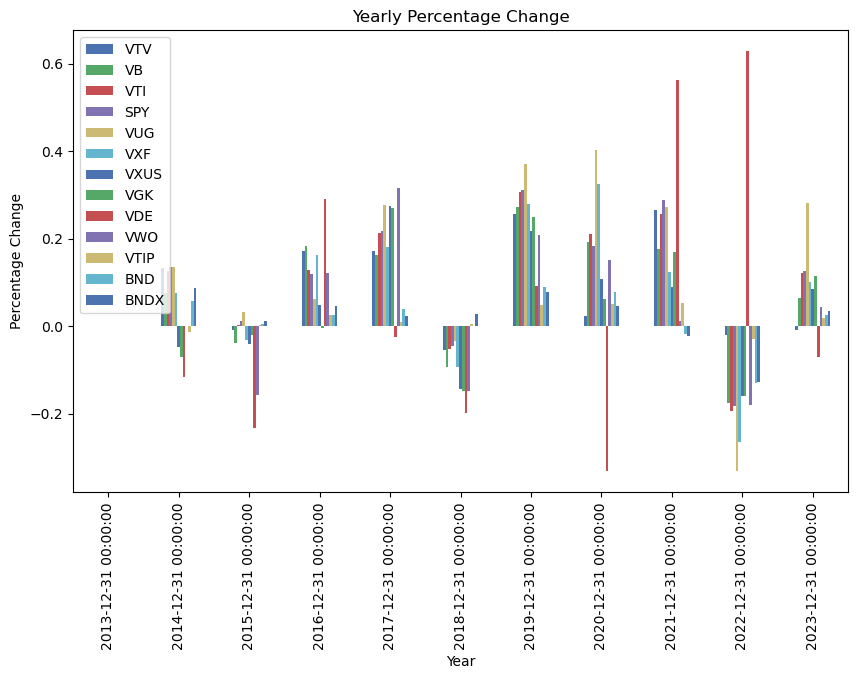

In [235]:
yearly_returns = df_vanguard.resample('Y').last().pct_change()
yearly_returns.plot(figsize=(10, 6),kind="bar")
plt.title('Yearly Percentage Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change')
plt.legend(loc='upper left')
plt.show()

In [201]:
symbols = ['VTV','VB', 'VTI', 'SPY','VUG','VXF','VXUS','VGK','VDE','VWO','VTIP','BND','BNDX']  
weights = [0.14 ,0.09, 0.12 , 0.08 ,0.04 ,0.05 ,0.05   ,0.04 ,0.03 ,0.03 ,0.03 ,0.15 ,0.15]
plt.rcParams["figure.figsize"] = (20,10)
print(len(symbols))

print(len(weights))
np.sum(weights)


13
13


1.0000000000000002

In [237]:
df_vanguard = pd.read_csv("vanguard.csv")
df_vanguard.head()


,Date,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
1,2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2,2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
3,2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
4,2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624


In [238]:

df_vanguard.Date = pd.to_datetime(df_vanguard['Date'], format='%Y-%m-%d')
df_vanguard.set_index(['Date'],inplace=True)
df_vanguard.head(2)

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
Date,,,,,,,,,,,,,
2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301


In [239]:
df_vanguard.columns

Index(['VTV', 'VB', 'VTI', 'SPY', 'VUG', 'VXF', 'VXUS', 'VGK', 'VDE', 'VWO',
       'VTIP', 'BND', 'BNDX'],
      dtype='object')

In [240]:
df_vanguard.head(10)

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
Date,,,,,,,,,,,,,
2013-06-04,53.297791,81.143036,70.319443,135.927887,71.788422,61.415333,36.059612,36.985325,84.341019,31.462042,40.631752,63.127640,40.591885
2013-06-05,52.577339,80.022179,69.325615,134.024811,70.790985,60.566608,35.402901,36.455208,83.380592,30.821037,40.631752,63.104568,40.640301
2013-06-06,53.096371,80.875801,69.977028,135.238113,71.339149,61.144108,35.619320,36.756062,83.974449,31.137758,40.607193,63.189159,40.583813
2013-06-07,53.747105,81.694878,70.845589,136.958496,72.255692,61.861576,35.835732,37.021122,85.030174,31.002026,40.525303,63.027752,40.503117
2013-06-10,53.801308,81.927666,70.870651,136.958496,72.219757,62.001606,35.805874,37.006805,84.744240,30.564638,40.525303,62.866375,40.212624
2013-06-11,53.266792,80.987862,70.152412,135.545685,71.464928,61.301590,35.305885,36.612816,83.512558,29.961336,40.443413,62.897072,40.204540
2013-06-12,52.918190,80.254982,69.559471,134.423706,70.701118,60.785355,35.246189,36.605644,82.933357,29.757711,40.451607,62.774139,40.365932
2013-06-13,53.685131,81.703499,70.636818,136.468201,71.833344,61.791573,35.783501,37.035454,84.370338,30.443966,40.484356,63.050827,40.228733
2013-06-14,53.328773,81.306862,70.235924,135.612137,71.464928,61.537849,35.343197,36.727428,83.585869,30.006578,40.533493,63.120010,40.325588


['SPY', 'VUG']


<Axes: xlabel='Date'>

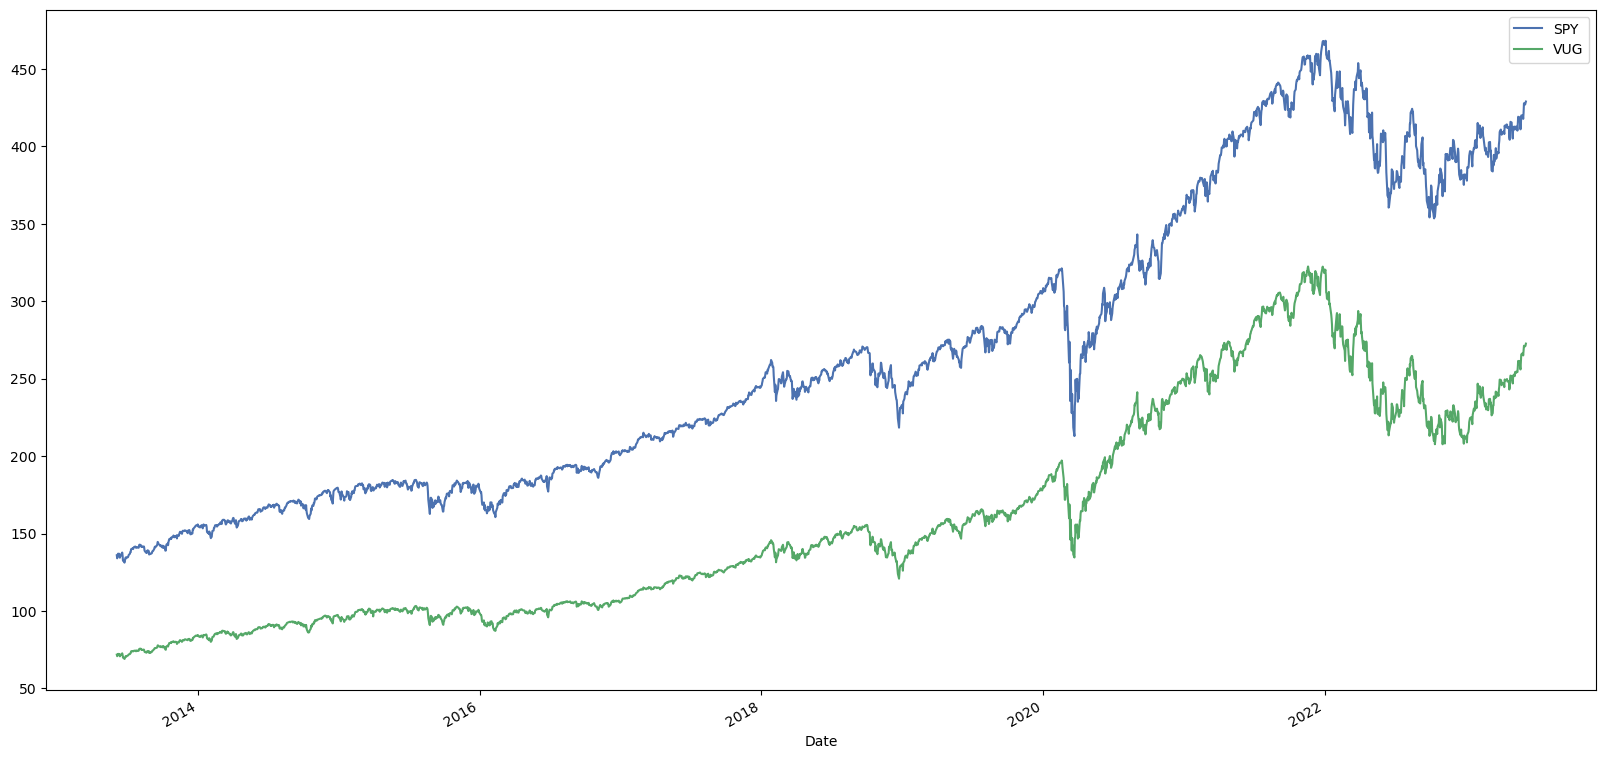

In [241]:
print(symbols[3:5])
df_vanguard[symbols[3:5]].plot()

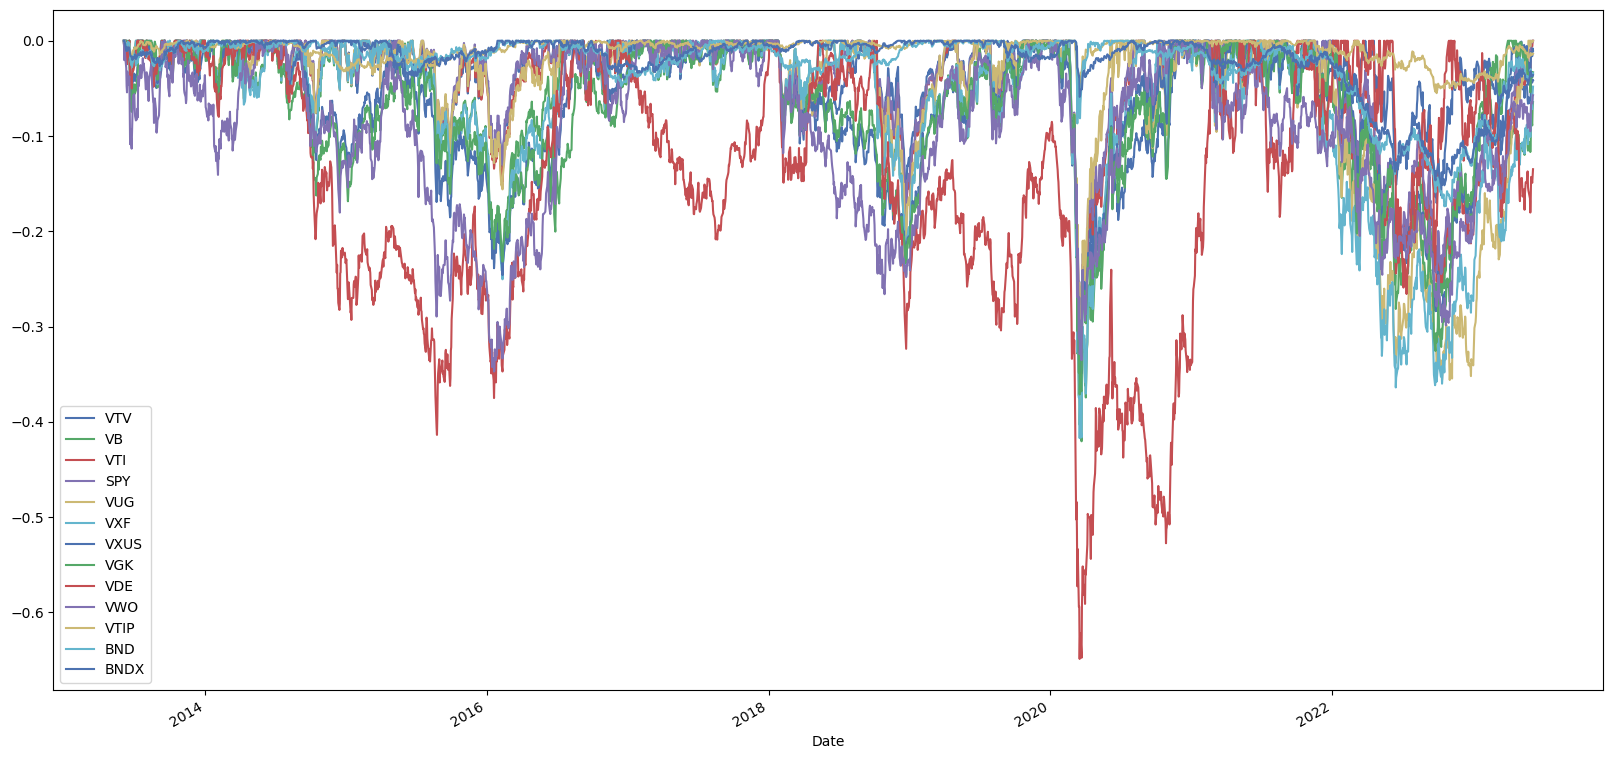

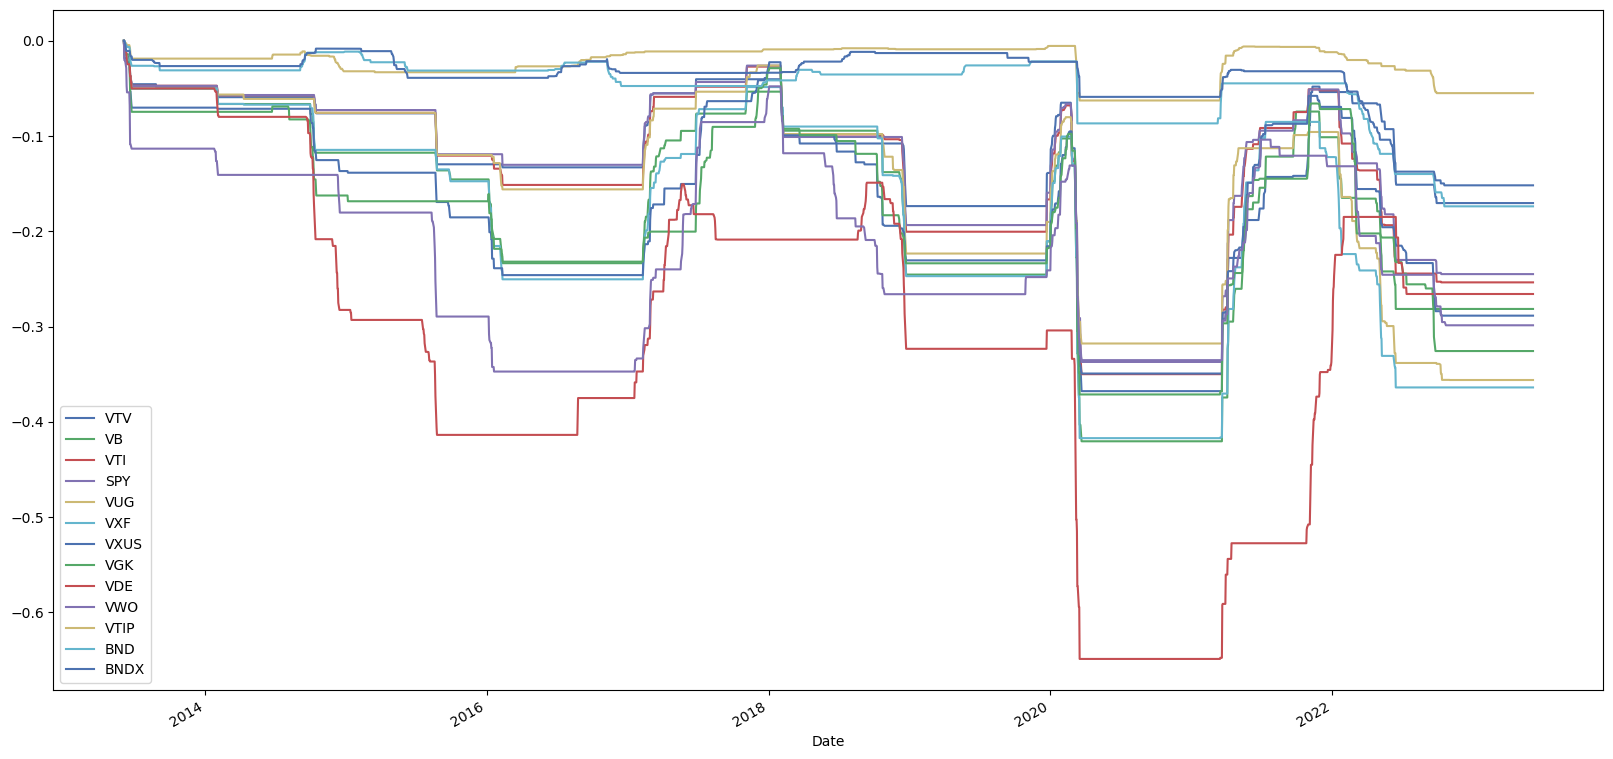

In [242]:
window = 252 #trading days per year

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = df_vanguard.rolling(window, min_periods=1).max()
Daily_Drawdown = df_vanguard/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.show()

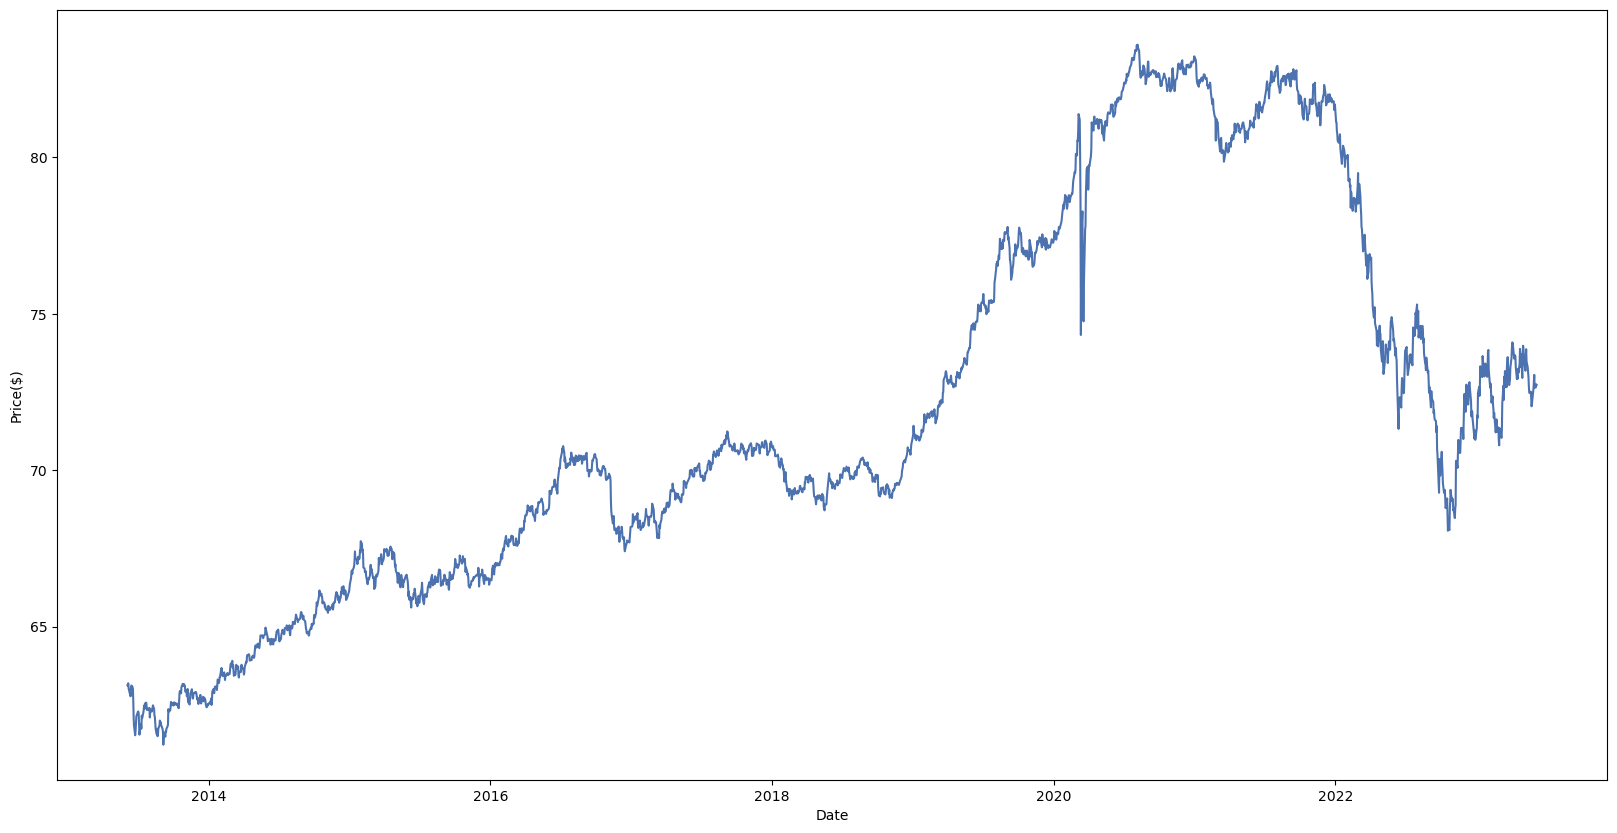

In [243]:
def stock_data(prices,col):
    

    df = pd.DataFrame({'Date':prices.index, 'Values':prices[col]})

    x = df.index.tolist()
    y = df['Values'].tolist()
    
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

     
    
    #plt.style.use('dark_background')
    plt.plot(x,y)
    
    plt.ylabel('Price($)')
    plt.xlabel('Date', rotation=0)
   
    plt.show()
stock_data(df_vanguard,"BND")        

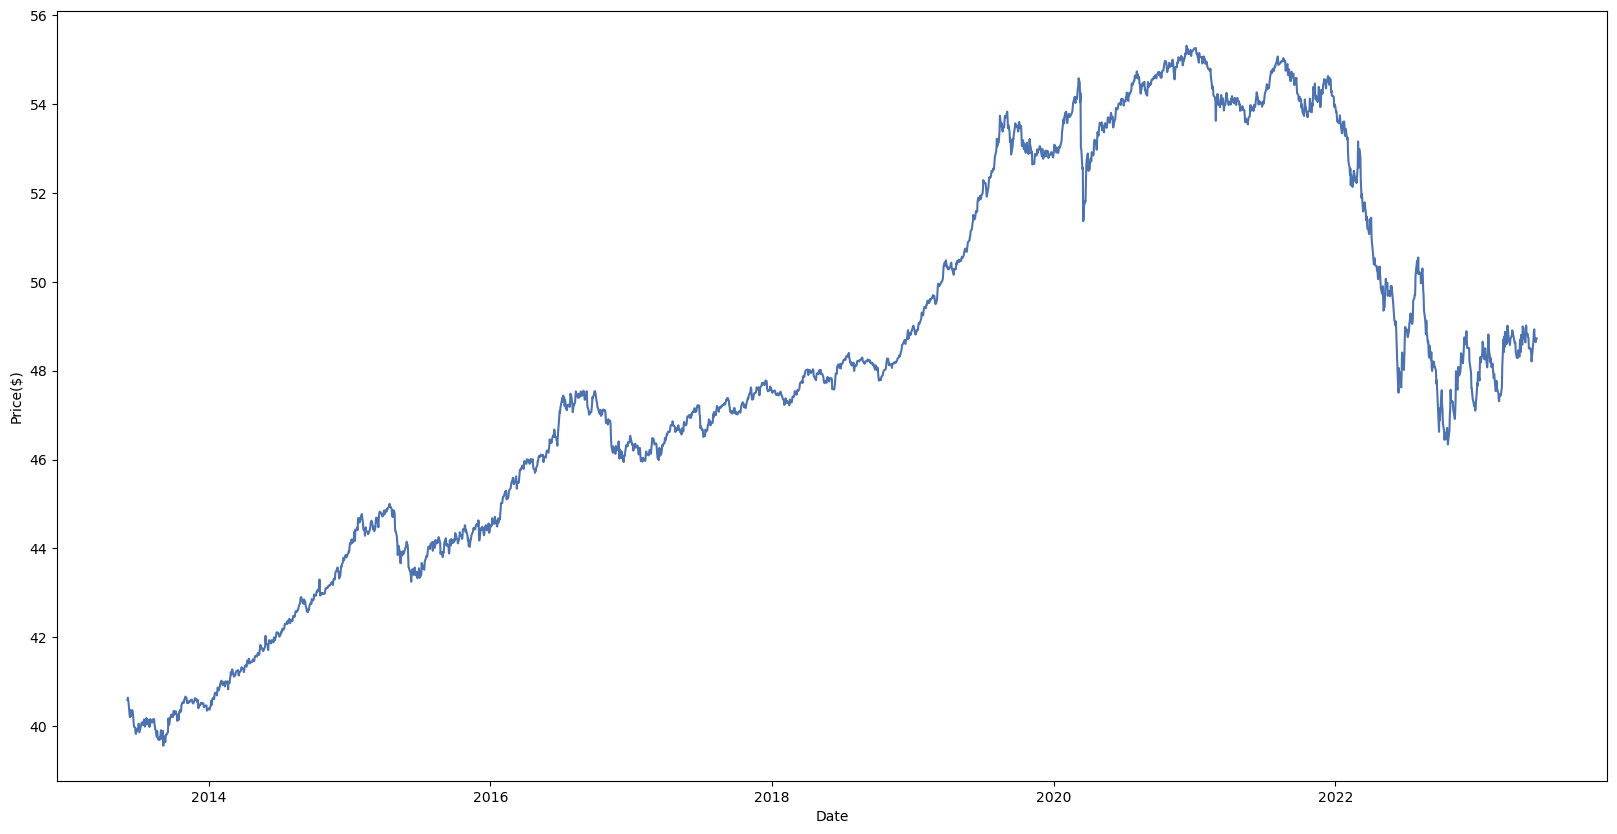

In [244]:
stock_data(df_vanguard,"BNDX")  

In [247]:

def plot_hist_returns(title,price_data,period,w):
    """
    price_data df with price data index by date
    w weight of each symbol fixed weight for ex ante hist
    """
    
    print("wt sum :",sum(w))
    ret_data = price_data.pct_change(periods=period)[1:]
    #print(ret_data.head())
    weighted_returns = (w * ret_data)
    #print(weighted_returns.head())
    port_ret = weighted_returns.sum(axis=1)
    mean_ret = np.mean(port_ret)
    vol_ret = np.std(port_ret)
    print("mean:",mean_ret)
    print("std dev:",vol_ret)
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
    ax1.hist(port_ret, bins = 60)
    ax1.set_xlabel('Portfolio returns')
    ax1.set_ylabel("Freq")
    ax1.set_title(title)
    plt.axvline(x = mean_ret, color = 'black', label = 'axvline - full height')
    plt.axvline(x = mean_ret + vol_ret, color = 'black', label = 'axvline - full height')
    plt.axvline(x = mean_ret - vol_ret, color = 'black', label = 'axvline - full height')
    plt.show();     


In [248]:
prices = df_vanguard
#wt_equal = [1 / len(prices.columns)] * len(prices.columns)
wt = weights

wt sum : 1.0000000000000002
mean: 0.0003071650206449226
std dev: 0.007598564716451975


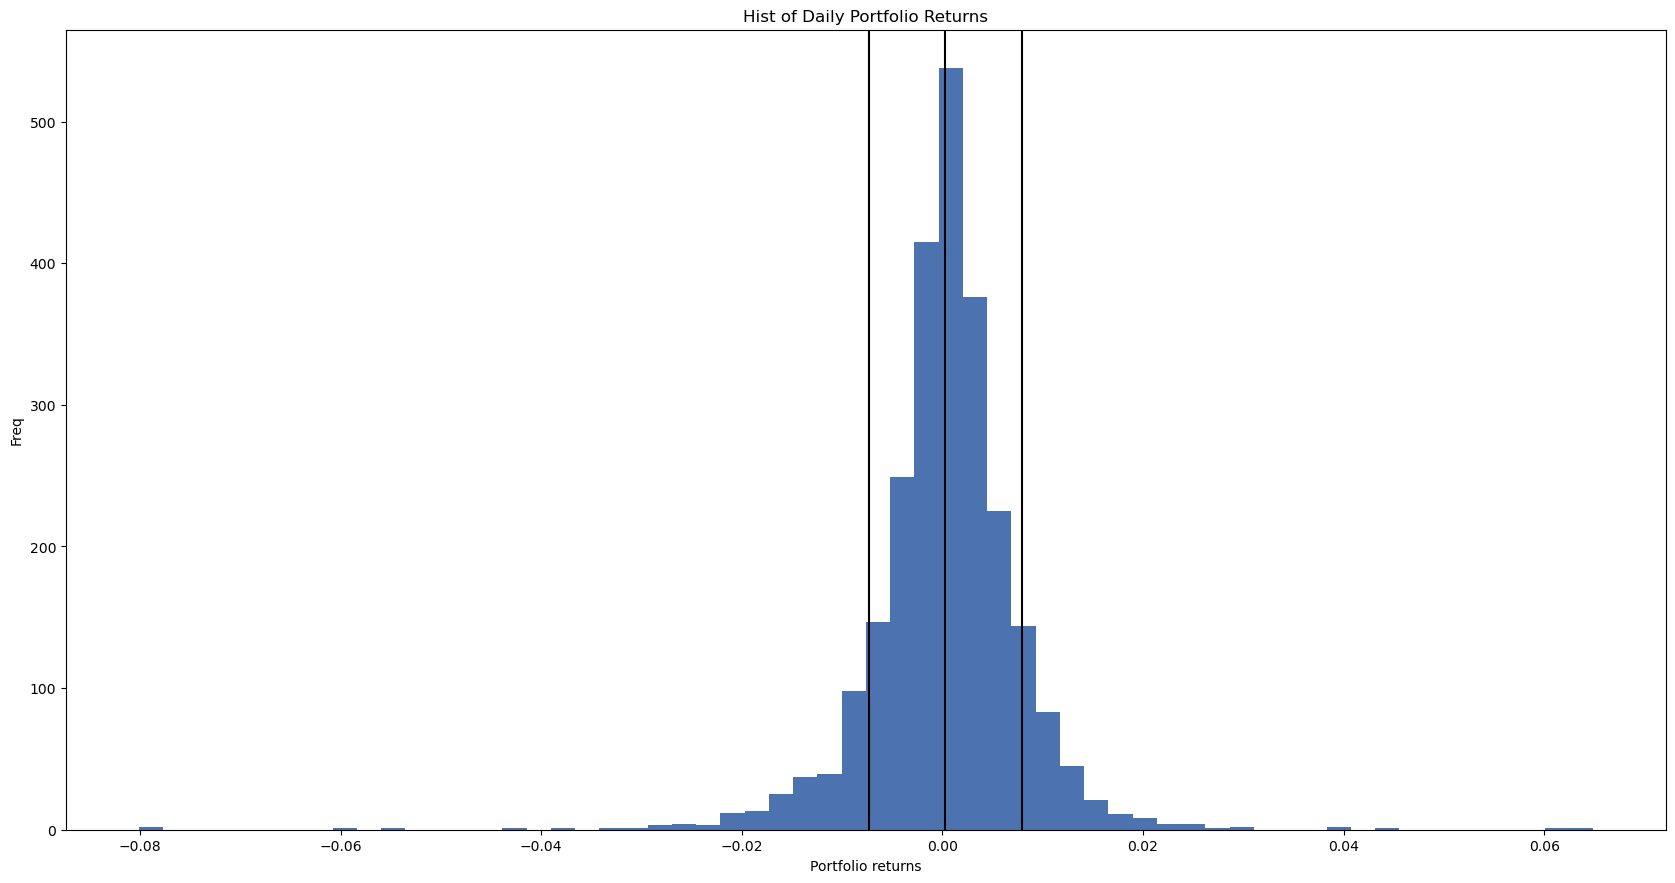

In [249]:
plot_hist_returns("Hist of Daily Portfolio Returns",prices,1,wt)

wt sum : 1.0000000000000002
mean: 0.0020975055446154525
std dev: 0.019069918785742303


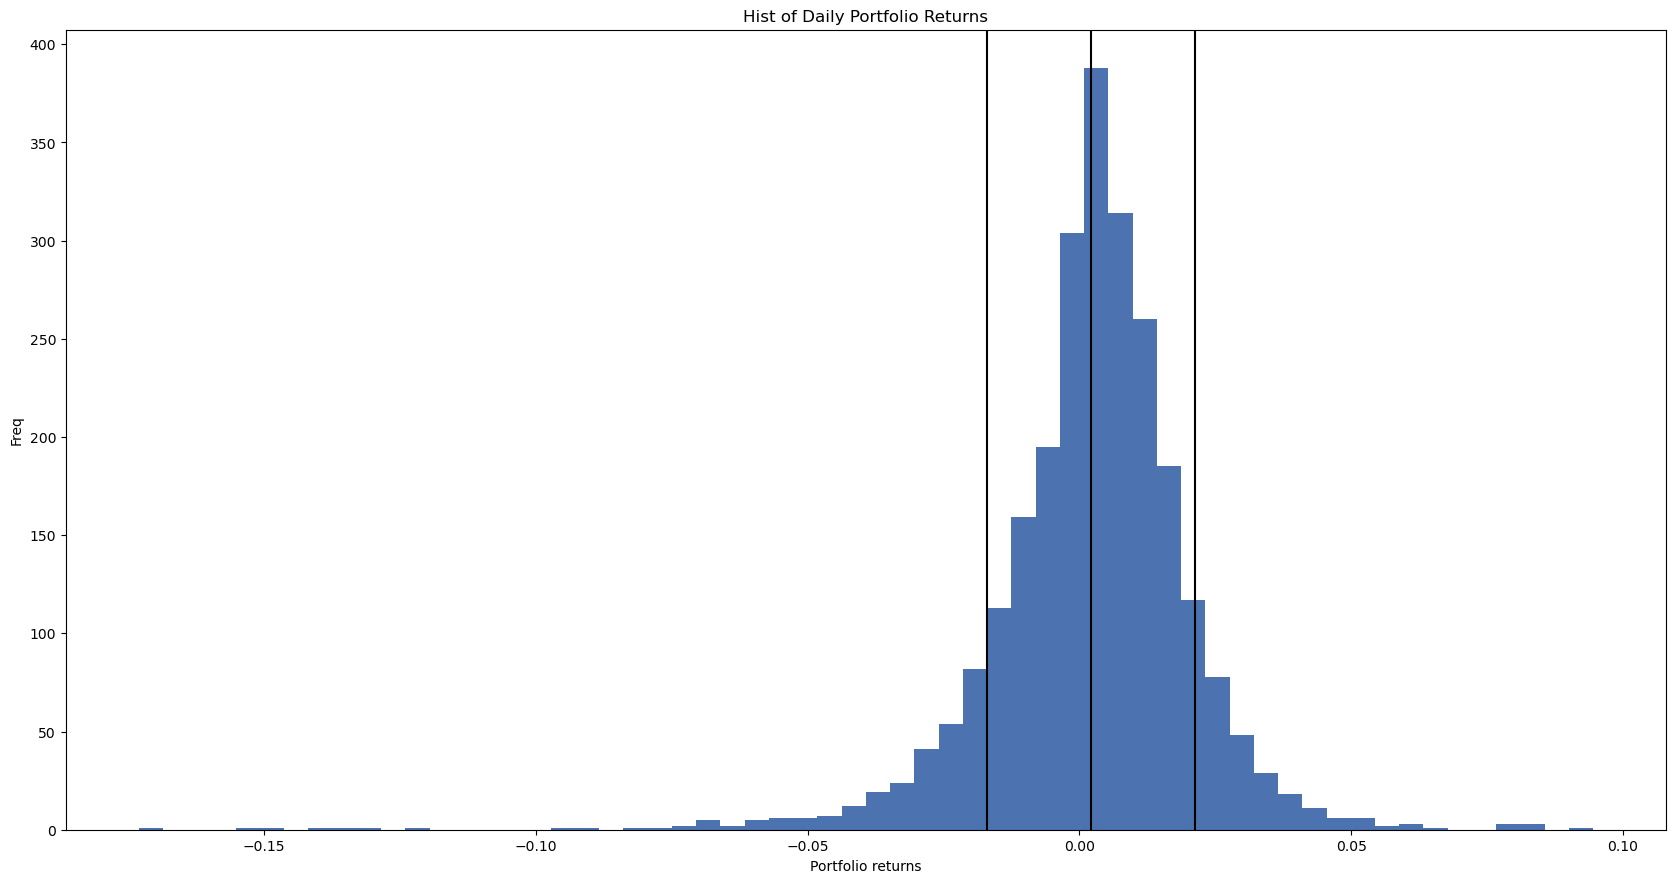

In [250]:
plot_hist_returns("Hist of Daily Portfolio Returns",prices,7,wt)

wt sum : 1.0000000000000002
mean: 0.00890072484943701
std dev: 0.037806728102379915


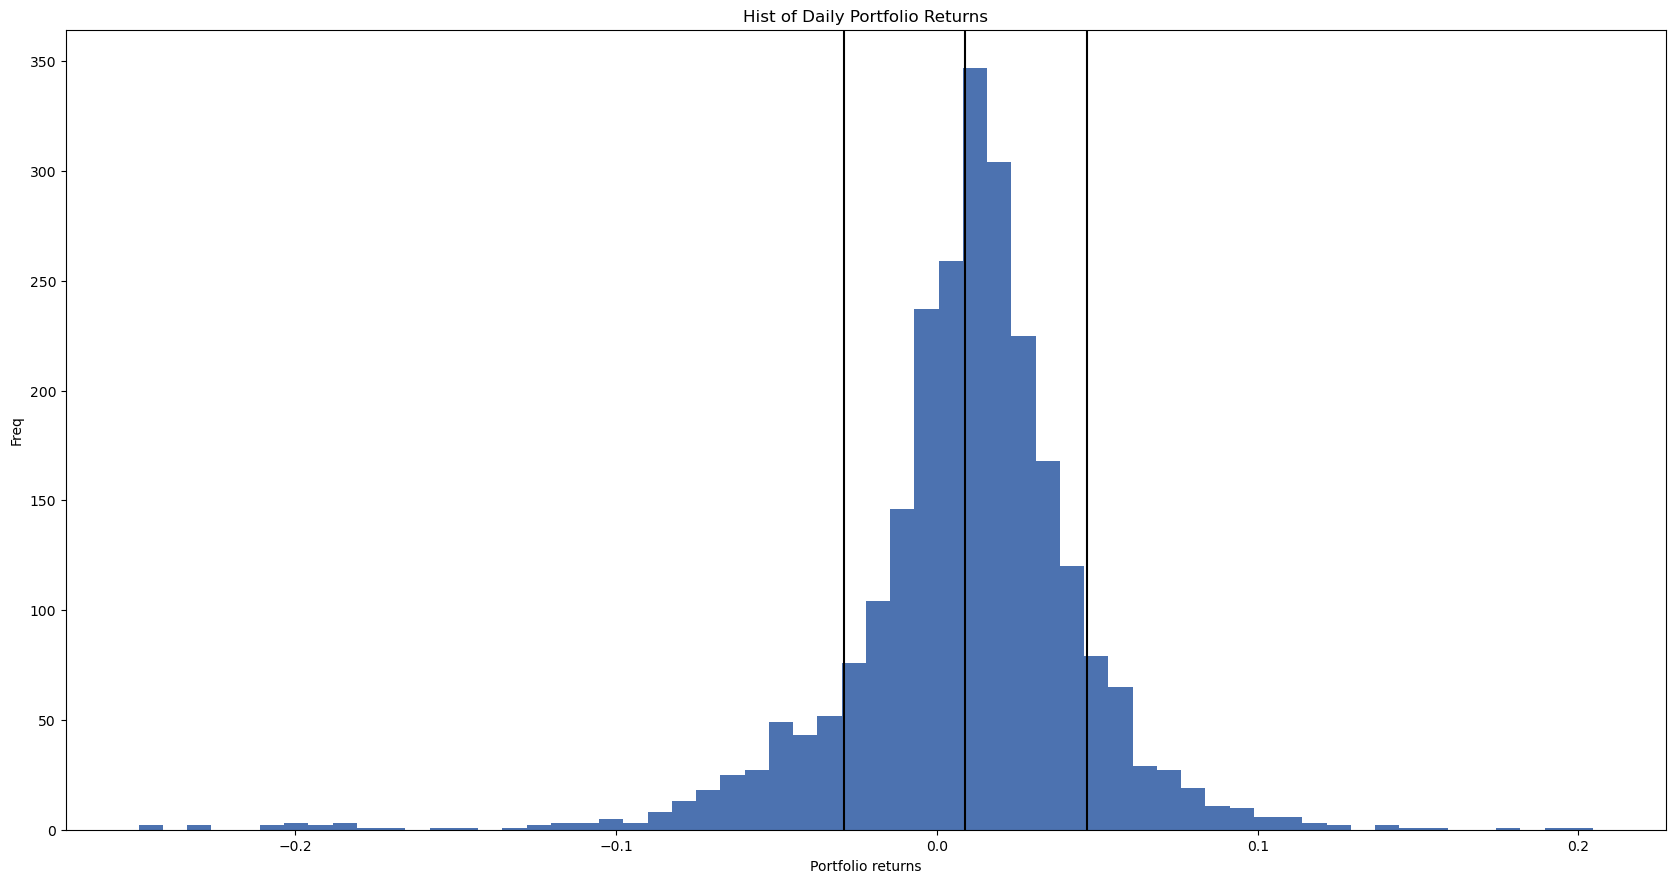

In [251]:
plot_hist_returns("Hist of Daily Portfolio Returns",prices,30,wt)

wt sum : 1.0000000000000002
mean: 0.02530805083961708
std dev: 0.0581095217278611


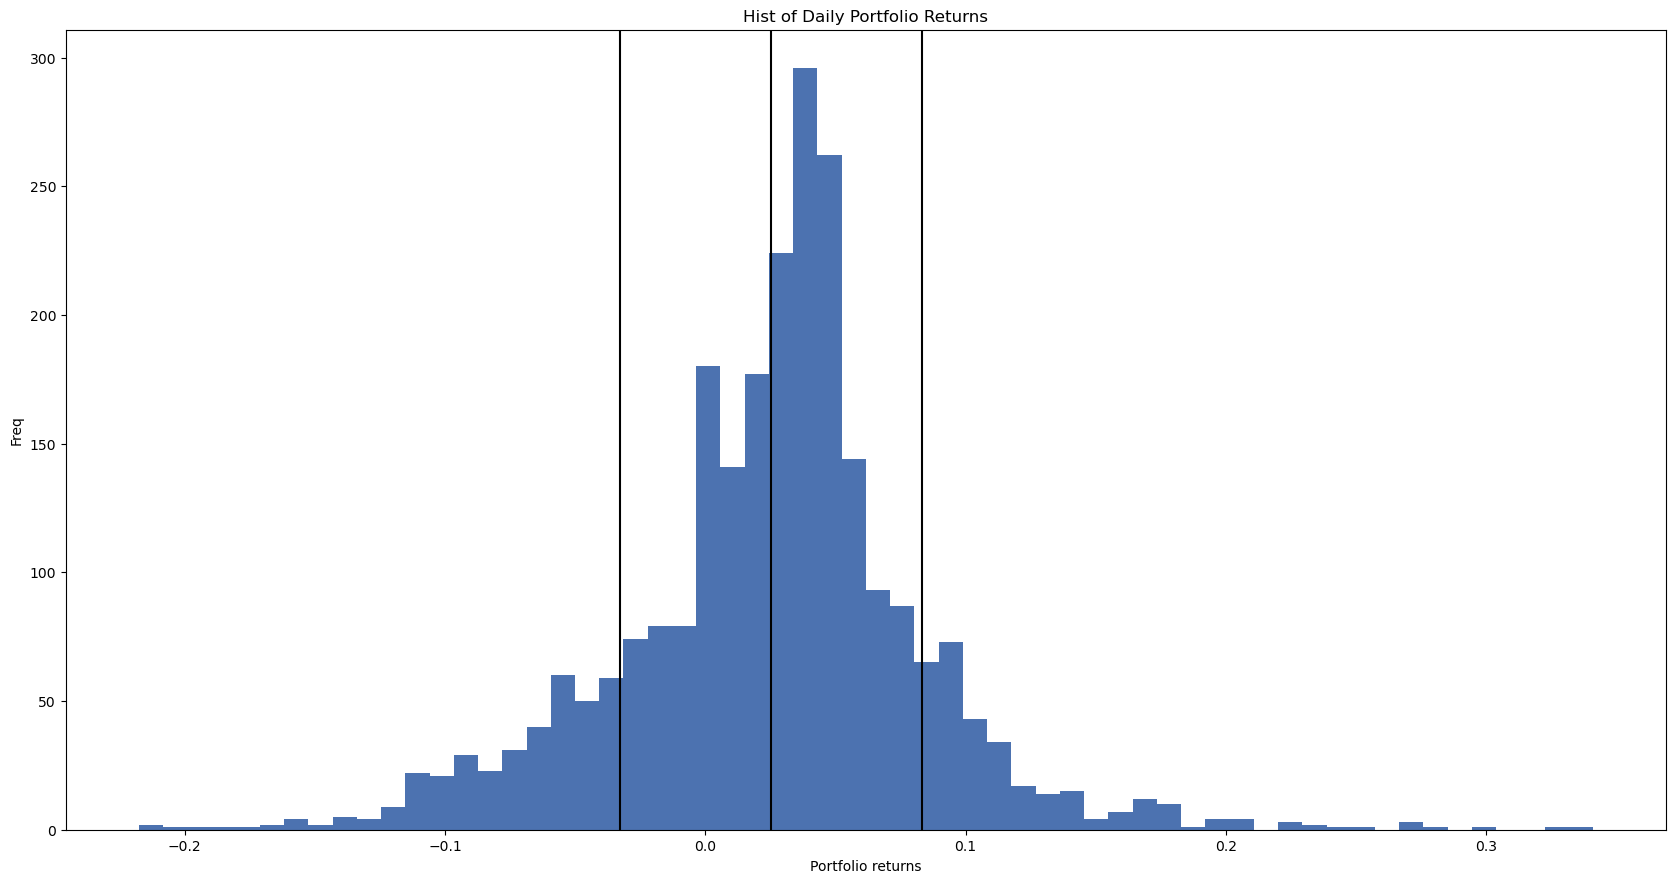

In [252]:
plot_hist_returns("Hist of Daily Portfolio Returns",prices,90,wt)


wt sum : 1.0000000000000002
mean: 0.06514118963018035
std dev: 0.10296857189169825


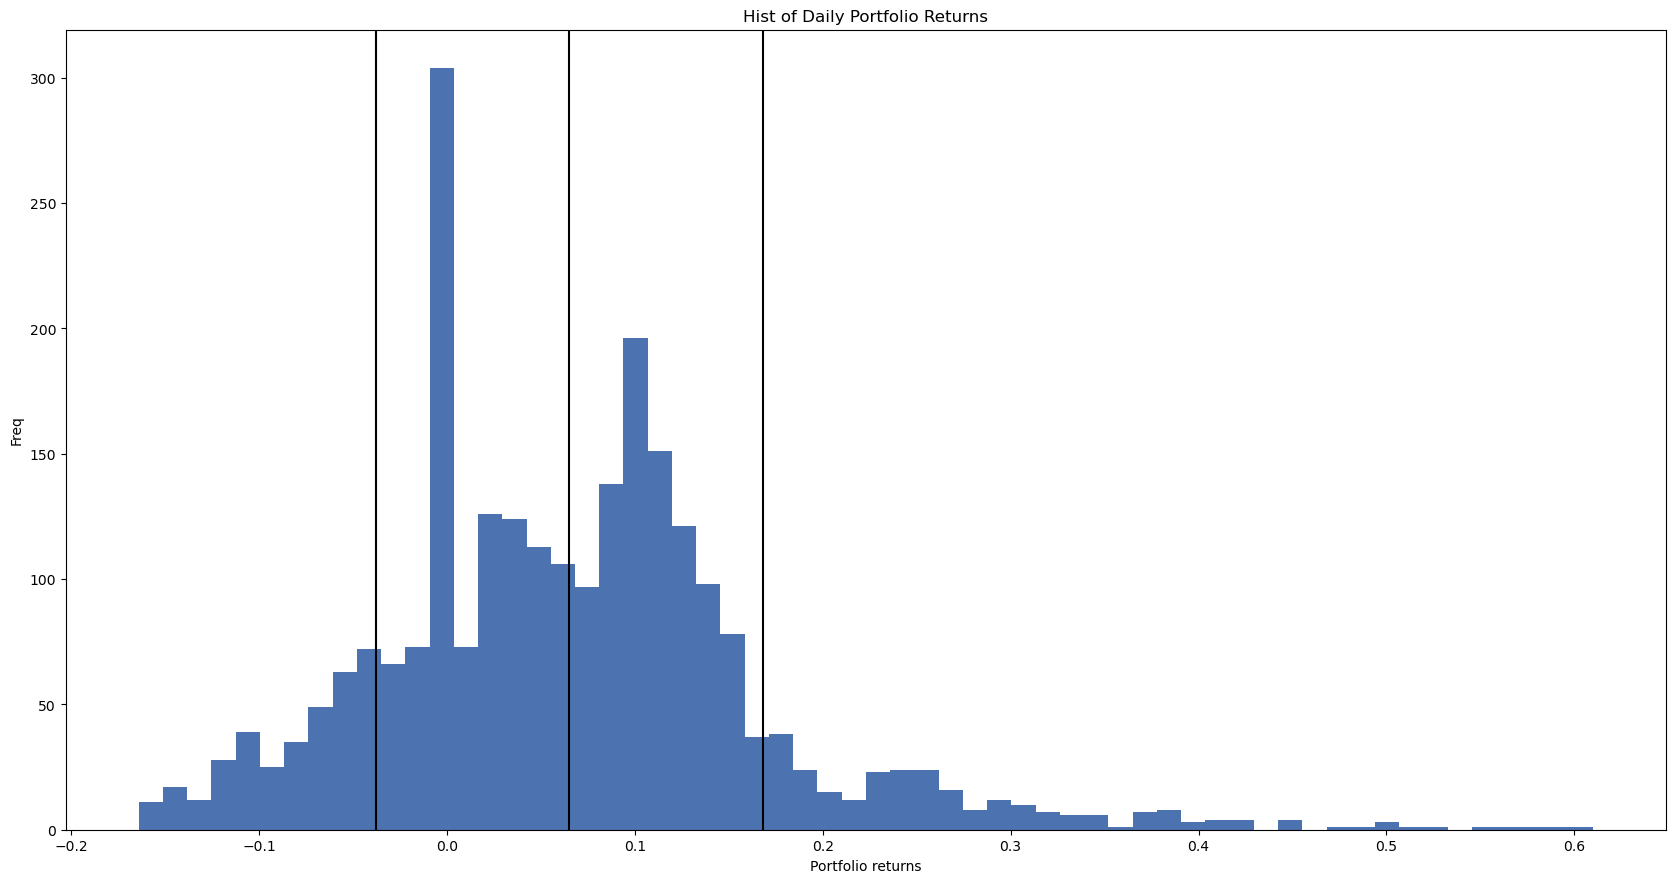

In [253]:
plot_hist_returns("Hist of Daily Portfolio Returns",prices,252,wt)


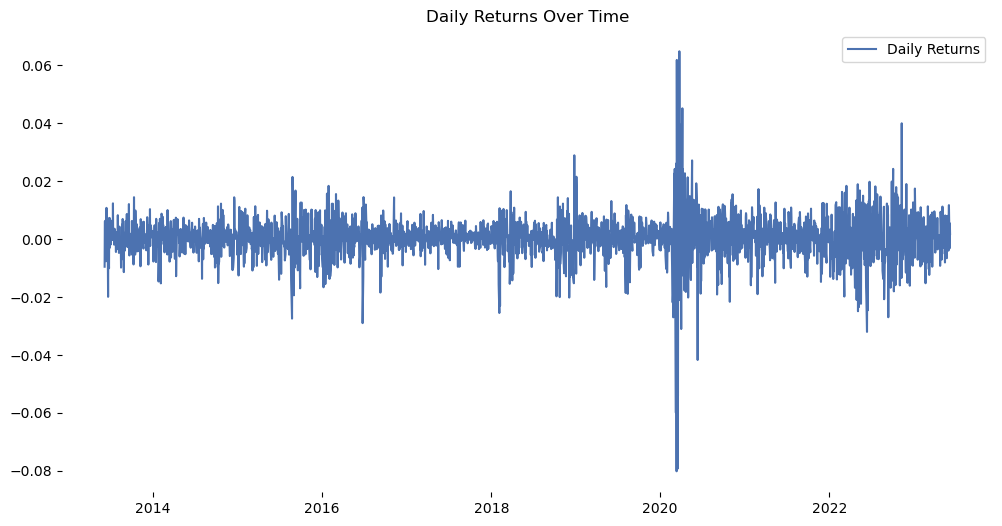

In [254]:

period = 1
ret_data = prices.pct_change(periods=period)[1:]
#print(ret_data.head())
weighted_returns = (wt * ret_data)
#print(weighted_returns.head())
port_ret = weighted_returns.sum(axis=1)


ret_data.dropna(inplace=True)
fig,ax=plt.subplots(figsize=(12,6))
ax.spines[['top','right','left','bottom']].set_visible(False)
plt.plot(port_ret, label = 'Daily Returns')
plt.legend(loc='best')
plt.title('Daily Returns Over Time')
plt.show()


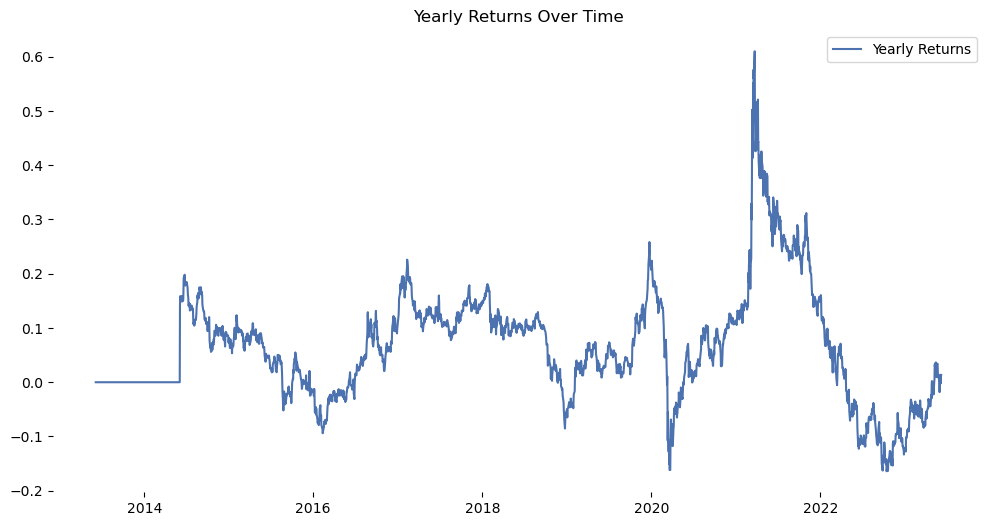

In [255]:

period = 252
ret_data = prices.pct_change(periods=period)[1:]
#print(ret_data.head())
weighted_returns = (wt * ret_data)
#print(weighted_returns.head())
port_ret = weighted_returns.sum(axis=1)


ret_data.dropna(inplace=True)
fig,ax=plt.subplots(figsize=(12,6))
ax.spines[['top','right','left','bottom']].set_visible(False)
plt.plot(port_ret, label = 'Yearly Returns')
plt.legend(loc='best')
plt.title('Yearly Returns Over Time')
plt.show()


In [258]:

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file

ef.portfolio_performance(verbose=True)


Expected annual return: 14.3%
Annual volatility: 20.2%
Sharpe Ratio: 0.61


(0.14277103456755635, 0.20208682808973444, 0.6075162628265965)

In [259]:
for symbol in cleaned_weights:
    print(symbol,"=>",cleaned_weights[symbol])

VTV => 0.0
VB => 0.0
VTI => 0.0
SPY => 0.0
VUG => 1.0
VXF => 0.0
VXUS => 0.0
VGK => 0.0
VDE => 0.0
VWO => 0.0
VTIP => 0.0
BND => 0.0
BNDX => 0.0


In [261]:

latest_prices = get_latest_prices(prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'VUG': 366}
Funds remaining: $199.12


#symbols = ['FDFIX','FLXSX','FLAPX','FITFX','FIBUX','BND','SHV']
#download_prices(symbols,"fidelity.csv")

<Axes: >

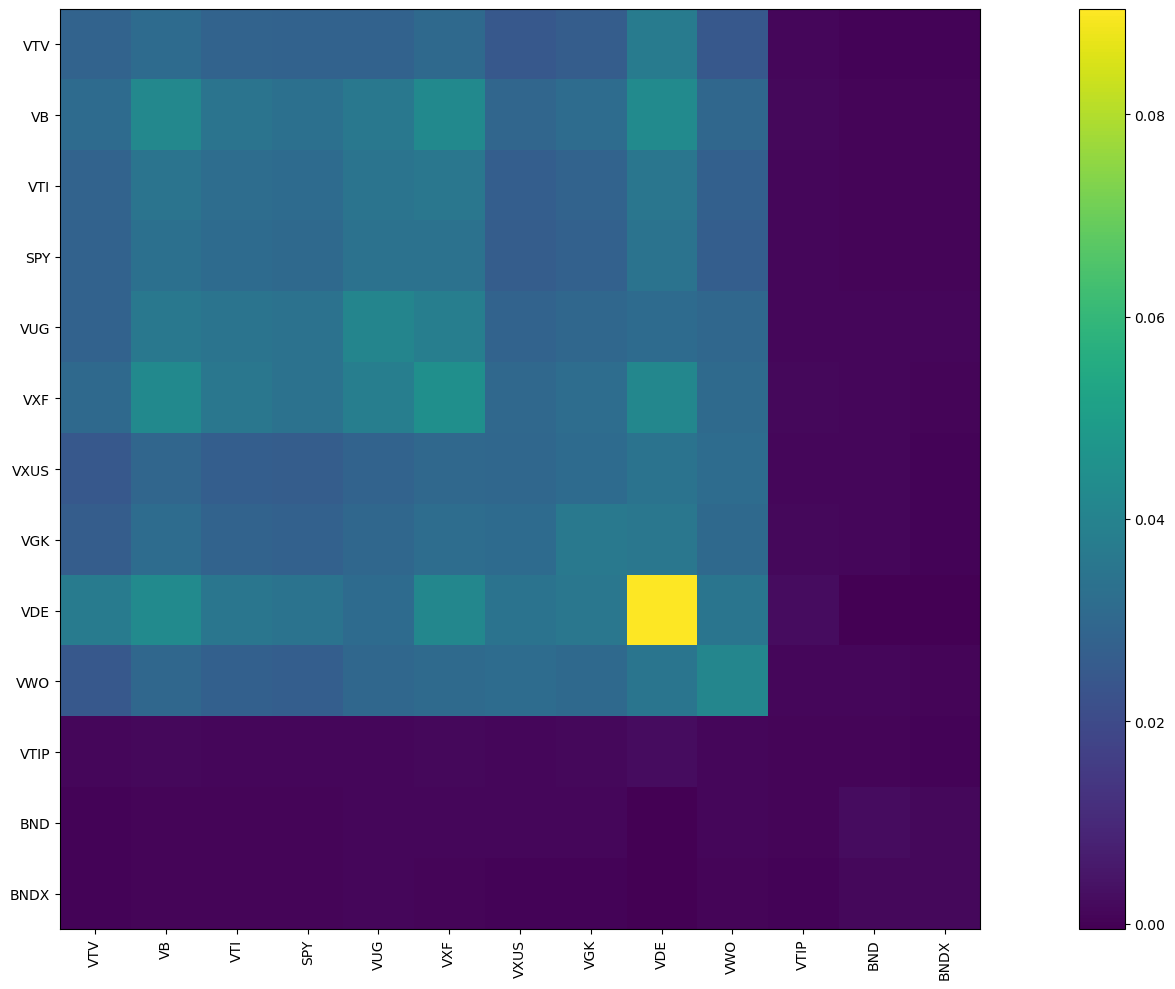

In [262]:

plot_covariance(S)


In [263]:
corr_df = prices.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
VTV,1.000000,0.970965,0.981338,0.985114,0.948067,0.930344,0.904895,0.900177,0.164308,0.826683,0.944776,0.730166,0.739740
VB,0.970965,1.000000,0.986896,0.981068,0.971046,0.988723,0.959929,0.941985,0.065907,0.907734,0.928153,0.778551,0.775116
VTI,0.981338,0.986896,1.000000,0.999138,0.991174,0.973013,0.935170,0.922371,0.046476,0.875114,0.965455,0.807462,0.791898
SPY,0.985114,0.981068,0.999138,1.000000,0.988363,0.962620,0.924823,0.914714,0.062105,0.860071,0.969667,0.799845,0.785112
VUG,0.948067,0.971046,0.991174,0.988363,1.000000,0.974408,0.927750,0.910871,-0.037341,0.879372,0.963230,0.846039,0.812348
VXF,0.930344,0.988723,0.973013,0.962620,0.974408,1.000000,0.964705,0.936977,-0.041389,0.932256,0.909209,0.823868,0.805845
VXUS,0.904895,0.959929,0.935170,0.924823,0.927750,0.964705,1.000000,0.985001,0.047982,0.973016,0.865301,0.755890,0.736358
VGK,0.900177,0.941985,0.922371,0.914714,0.910871,0.936977,0.985001,1.000000,0.141964,0.929101,0.864981,0.690398,0.662546
VDE,0.164308,0.065907,0.046476,0.062105,-0.037341,-0.041389,0.047982,0.141964,1.000000,-0.044824,0.133239,-0.500478,-0.494964
VWO,0.826683,0.907734,0.875114,0.860071,0.879372,0.932256,0.973016,0.929101,-0.044824,1.000000,0.802021,0.767137,0.740792


<Figure size 2000x1000 with 0 Axes>

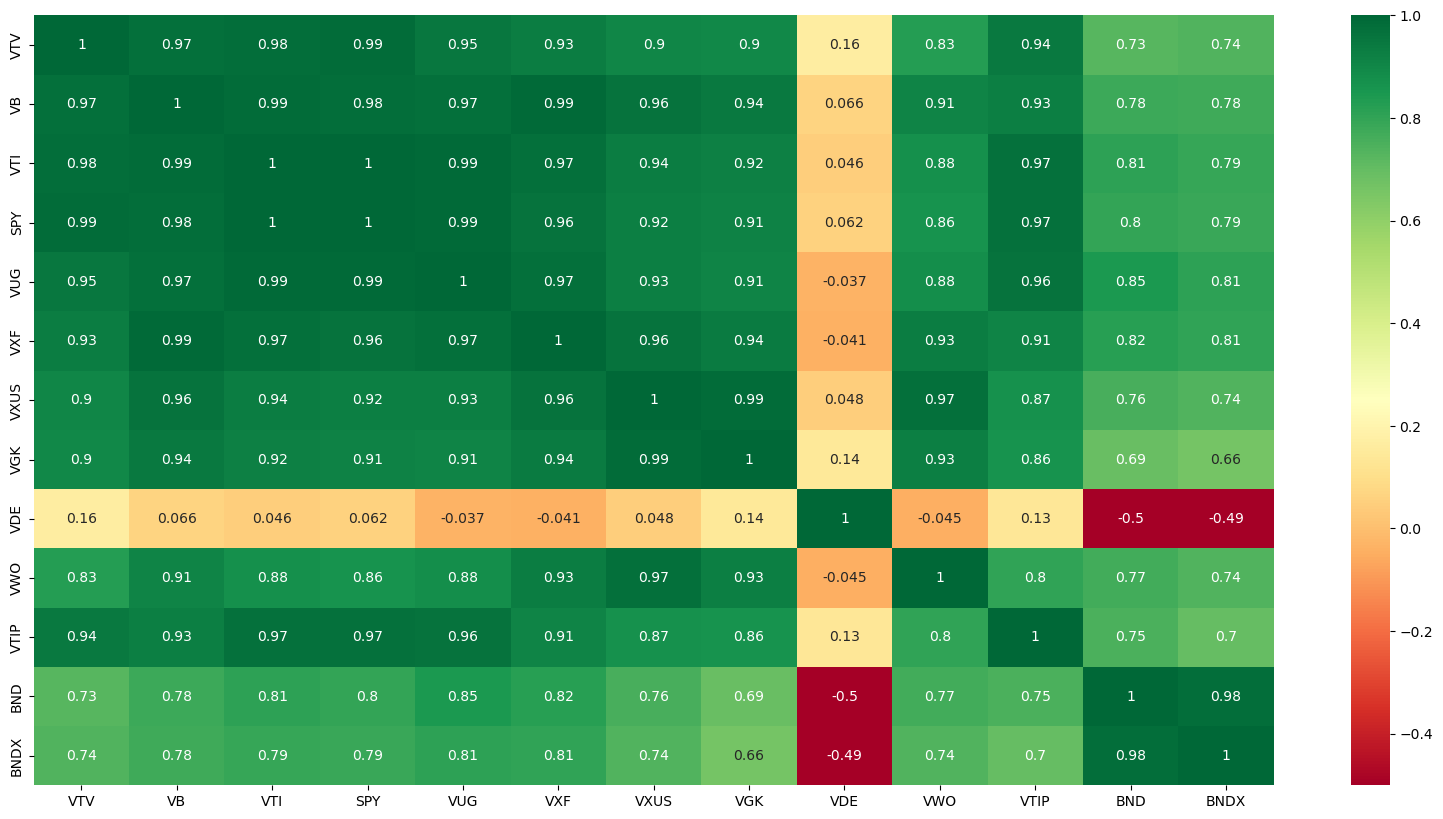

<Figure size 2000x1000 with 0 Axes>

In [264]:
#plt.figure(figsize=(13, 8))
seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
plt.figure()

In [265]:



# Building the portfolio object
port = rp.Portfolio(returns=ret_data)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)


,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
weights,0.185374,1.462063e-10,6.633949e-10,0.073187,3.774742e-09,1.106553e-10,1.188180e-10,1.168168e-10,4.313063e-10,1.008952e-10,0.550467,2.520348e-09,0.190972


C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


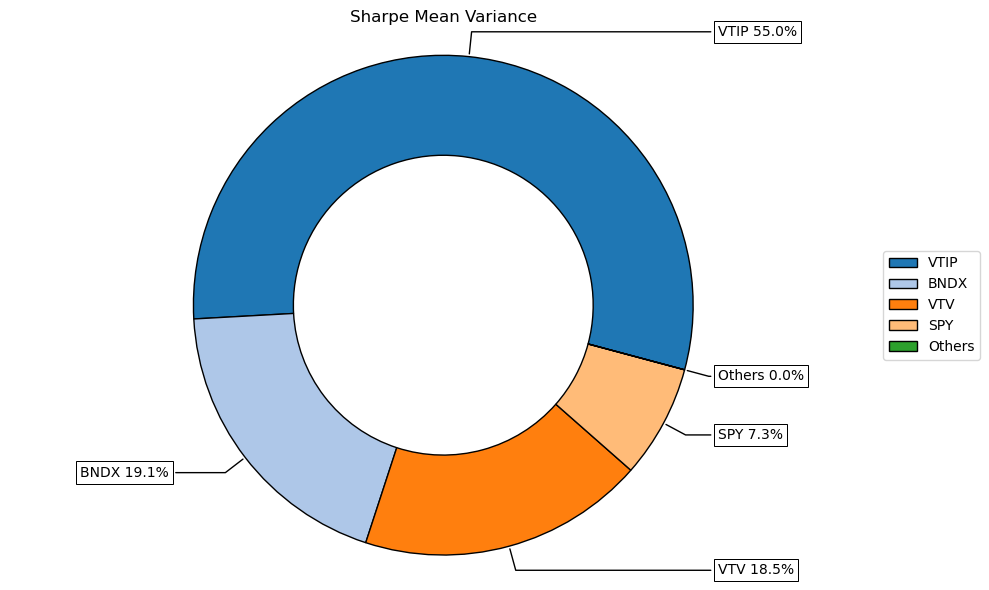

In [266]:

    
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


In [267]:
points = 50 # Number of points of the frontier
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
display(frontier.T.head())

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,1.019785e-11,4.601599e-12,5.205116e-12,5.784335e-12,3.787701e-12,3.504670e-12,6.192468e-12,6.289274e-12,2.936235e-03,5.205902e-12,0.868963,5.165100e-11,0.128101
1,5.663374e-02,1.097836e-09,3.152571e-09,6.854337e-09,4.132131e-09,8.260561e-10,8.399745e-10,8.232979e-10,8.331728e-03,6.978598e-10,0.749642,1.083562e-08,0.185393
2,1.078463e-01,1.975366e-09,5.795746e-09,1.444732e-08,5.768092e-09,1.421822e-09,1.663805e-09,1.656529e-09,3.505852e-08,1.384805e-09,0.726404,2.110419e-08,0.165750
3,1.469036e-01,6.094431e-10,2.636619e-09,2.356094e-08,7.078409e-09,4.622203e-10,4.924030e-10,4.837301e-10,2.355460e-09,4.179066e-10,0.673101,9.293417e-09,0.179995
4,1.816738e-01,1.083953e-09,5.016516e-09,9.616280e-04,2.825768e-08,8.168624e-10,8.722877e-10,8.600596e-10,3.437196e-09,7.318499e-10,0.624683,1.634172e-08,0.192682


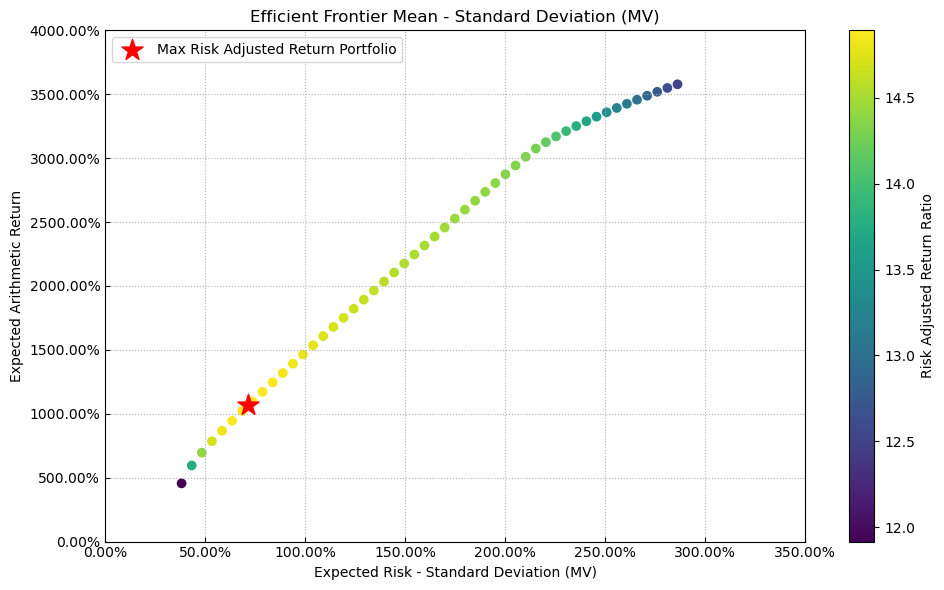

In [268]:
 
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

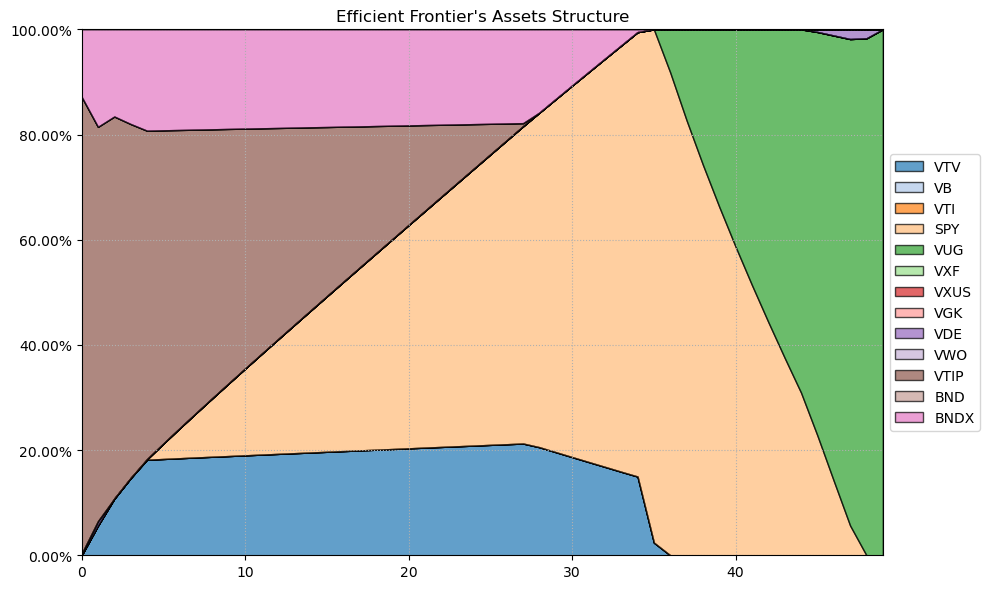

In [269]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)



In [270]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
weights,0.309912,5.128846e-15,3.126367e-14,1.164661e-13,4.874544e-14,2.262167e-15,1.294654e-15,2.109584e-15,0.005961,5.853219e-16,0.684127,4.689196e-14,6.251302e-14


C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


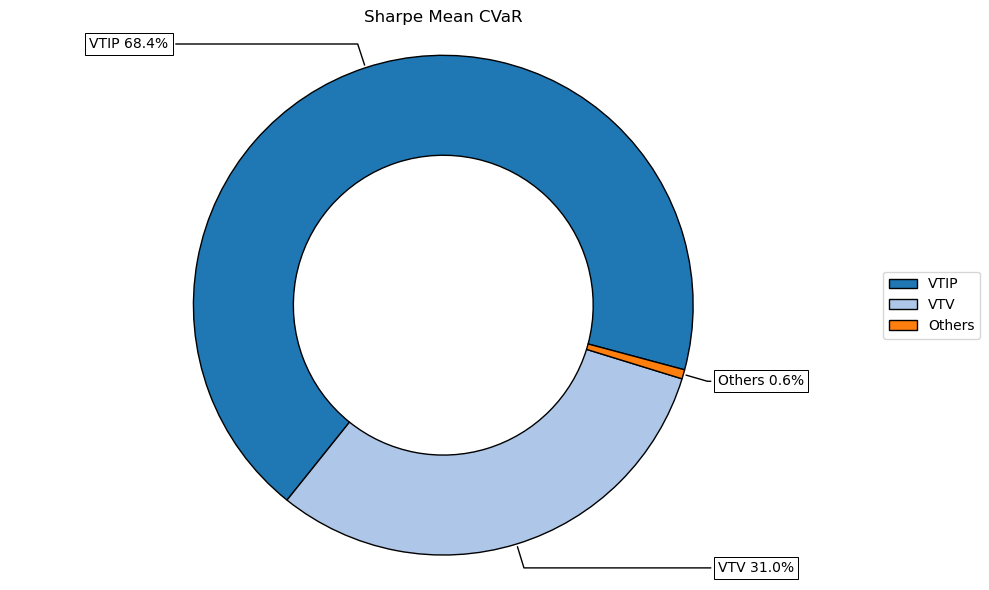

In [271]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


In [272]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,0.075890,7.065223e-15,1.366861e-14,3.992478e-14,4.465766e-14,3.024284e-15,1.257232e-15,2.531698e-15,1.568628e-02,3.015691e-16,0.908424,2.688542e-14,7.863060e-14
1,0.231391,2.693620e-14,1.330026e-13,4.091876e-13,1.663651e-13,1.082476e-14,3.495331e-15,8.688007e-15,1.099365e-02,6.154967e-15,0.757616,1.643055e-13,2.485760e-13
2,0.322425,9.821327e-13,6.807365e-12,3.290531e-11,1.250043e-11,3.811758e-13,1.747317e-13,3.692503e-13,5.350241e-03,2.467256e-13,0.672224,7.870590e-12,1.027590e-11
3,0.399931,1.916374e-13,1.812953e-12,2.006476e-11,7.223461e-12,7.389167e-14,3.523010e-14,6.858839e-14,3.452121e-11,5.071537e-14,0.600069,1.957506e-12,2.294153e-12
4,0.435970,1.613969e-13,1.828649e-12,2.591127e-02,3.303548e-11,6.559131e-14,2.445719e-14,3.900696e-14,1.065667e-11,4.303690e-14,0.538119,2.038196e-12,2.200717e-12


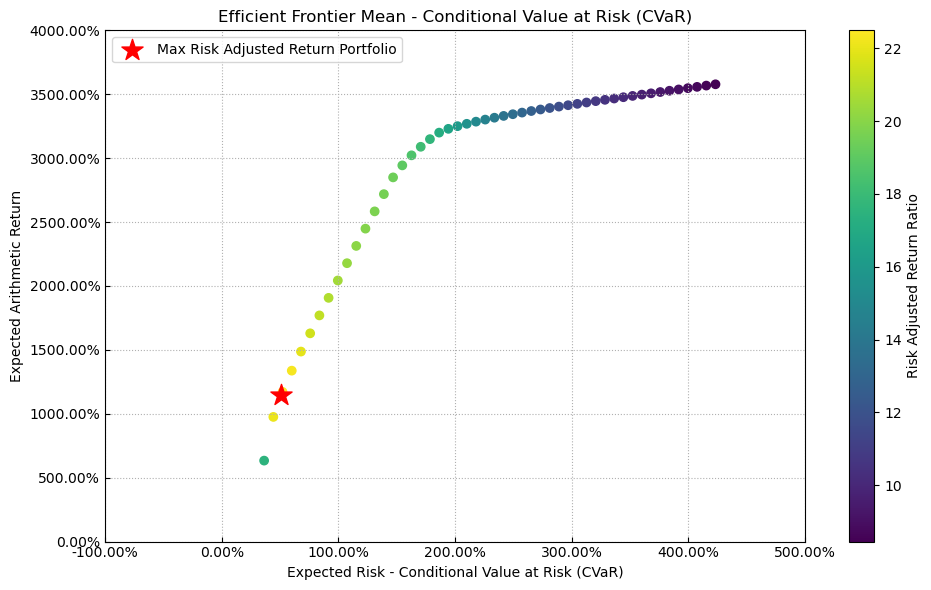

In [273]:

label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

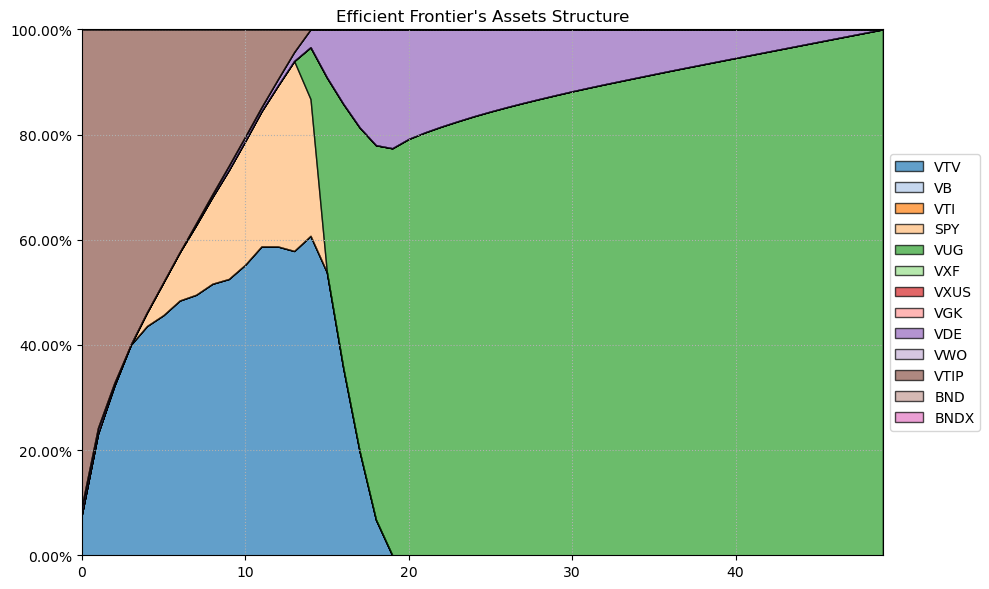

In [274]:


# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)


w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

In [275]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w.T)


,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
weights,0.309912,5.128846e-15,3.126367e-14,1.164661e-13,4.874544e-14,2.262167e-15,1.294654e-15,2.109584e-15,0.005961,5.853219e-16,0.684127,4.689196e-14,6.251302e-14


In [ ]:

ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


<Axes: >

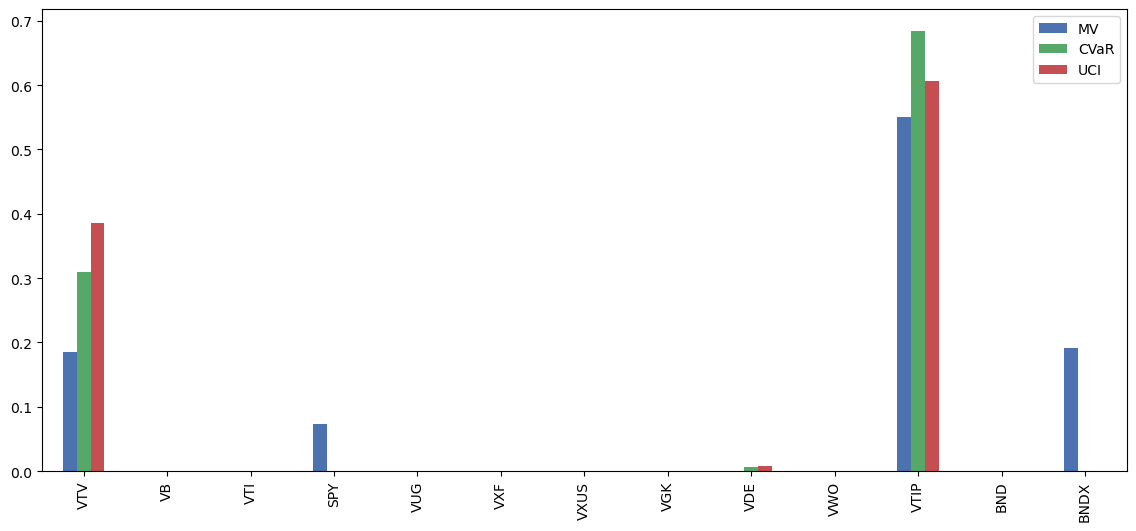

In [276]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

rms = ['MV', 'CVaR', 'UCI']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [277]:
Y = prices.copy()
Y = Y.resample('M').last().pct_change().dropna() #monthly

In [278]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

#port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.04 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'



In [279]:
w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
VTV,8.539228e-10,8.539228e-10,8.539228e-10
VB,5.311598e-10,5.311598e-10,5.311598e-10
VTI,6.043390e-10,6.043390e-10,6.043390e-10
SPY,6.246901e-10,6.246901e-10,6.246901e-10
VUG,4.849366e-10,4.849366e-10,4.849366e-10
VXF,5.089343e-10,5.089343e-10,5.089343e-10
VXUS,5.539152e-10,5.539152e-10,5.539152e-10
VGK,4.910209e-10,4.910209e-10,4.910209e-10
VDE,3.708701e-10,3.708701e-10,3.708701e-10
VWO,6.222262e-10,6.222262e-10,6.222262e-10


<Axes: >

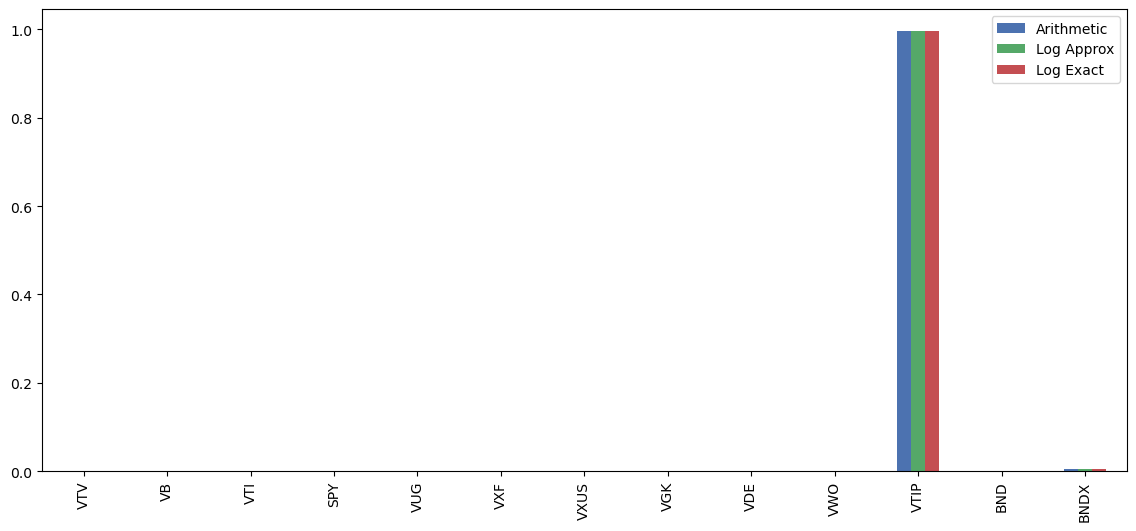

In [280]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [281]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 0.7126782498526871
Log Approx 0.7126782498526871
Log Exact 0.7126782498526871


In [282]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,8.539228e-10,5.311598e-10,6.043390e-10,6.246901e-10,4.849366e-10,5.089343e-10,5.539152e-10,4.910209e-10,3.708701e-10,6.222262e-10,0.996279,6.782238e-09,0.003721
1,3.456258e-02,2.198644e-10,1.399185e-09,3.565538e-08,1.967500e-02,1.912760e-10,1.279299e-10,1.238052e-10,8.219993e-11,1.241663e-10,0.879989,1.026135e-09,0.065773
2,3.900960e-02,4.729222e-10,2.974823e-09,1.259152e-07,5.091177e-02,3.989322e-10,2.817046e-10,2.786674e-10,1.912064e-10,2.691933e-10,0.848495,2.355645e-09,0.061584
3,4.301779e-02,8.264614e-10,4.745851e-09,2.826073e-07,7.909084e-02,6.958400e-10,5.041121e-10,4.984183e-10,3.511654e-10,4.825635e-10,0.820088,4.286728e-09,0.057803
4,4.678737e-02,1.218950e-09,7.090935e-09,4.546148e-07,1.055915e-01,1.016871e-09,7.403189e-10,7.298945e-10,5.237839e-10,7.107184e-10,0.793350,6.206430e-09,0.054270


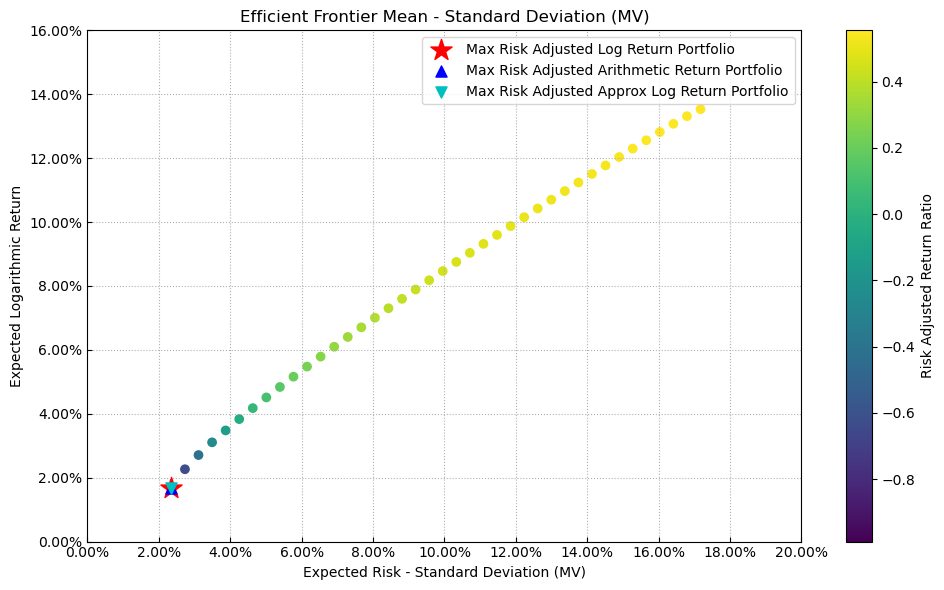

In [283]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

In [284]:
rm = 'EDaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,Arithmetic,Log Approx,Log Exact
VTV,0.000018,0.000018,0.000018
VB,0.000007,0.000007,0.000007
VTI,0.000007,0.000007,0.000007
SPY,0.000008,0.000008,0.000008
VUG,0.000005,0.000005,0.000005
VXF,0.000005,0.000005,0.000005
VXUS,0.000003,0.000003,0.000003
VGK,0.000003,0.000003,0.000003
VDE,0.006282,0.006282,0.006282
VWO,0.000003,0.000003,0.000003


<Axes: >

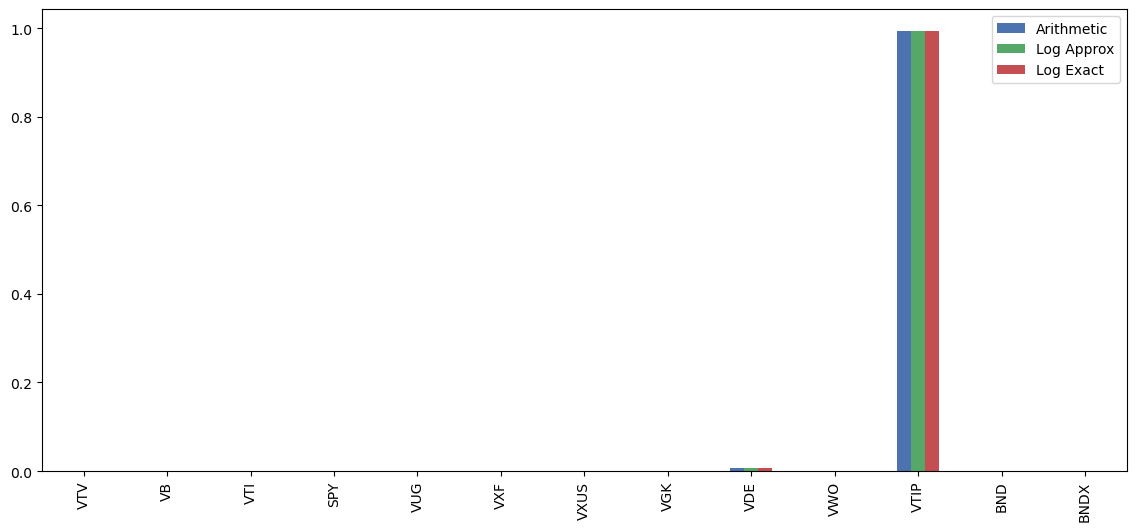

In [285]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [286]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12)

Risk Adjusted Return:
Arithmetic 0.444090615309489
Log Approx 0.444090615309489
Log Exact 0.444090615309489


C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\unmes\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\unmes\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\unmes\anaconda3\lib\site-packages\scipy\op

In [287]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\unmes\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\unmes\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjust

,VTV,VB,VTI,SPY,VUG,VXF,VXUS,VGK,VDE,VWO,VTIP,BND,BNDX
0,0.000018,0.000007,0.000007,0.000008,0.000005,0.000005,0.000003,0.000003,0.006282,0.000003,0.993613,0.000016,0.000029
1,0.014450,0.000018,0.000076,0.097418,0.001169,0.000011,0.000007,0.000007,0.023483,0.000007,0.863289,0.000028,0.000038
2,0.000698,0.000008,0.000034,0.122169,0.027564,0.000005,0.000003,0.000003,0.032018,0.000003,0.817464,0.000014,0.000017
3,0.000208,0.000004,0.000020,0.106308,0.075774,0.000003,0.000002,0.000002,0.043585,0.000002,0.774072,0.000009,0.000010
4,0.000136,0.000004,0.000017,0.089971,0.123315,0.000003,0.000002,0.000002,0.054905,0.000002,0.731626,0.000008,0.000009


In [ ]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()